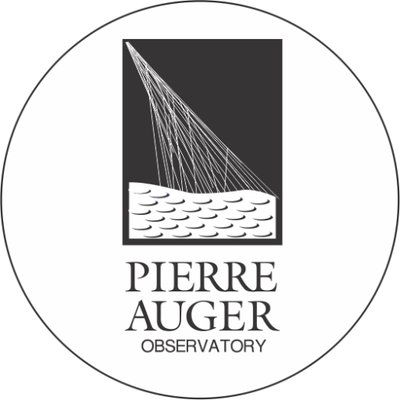
# Measurement of the tail of the $X_\text{max}$ distribution, and the proton-air cross section  

<i>Notebook released together with the Pierre Auger Observatory Open Data release 2021 (<a href="https://doi.org/10.5281/zenodo.4487612">DOI 10.5281/zenodo.4487612</a>). More information at the <a href="https://www.auger.org/opendata/">Auger open data website</a>.</i>

This notebook illustrates the analysis as published in [Measurement of the proton-air cross-section at $\sqrt{s}=57$ TeV with the Pierre Auger Observatory, Phys.Rev.Lett. 109 (2012), 062002](https://doi.org/10.1103/PhysRevLett.109.062002) ([arXiv](https://arxiv.org/abs/1208.1520)). However, the procedure has been a bit simplified here with respect to the original paper:
- The same event selection is used as for the measurement of $\langle X_\text{max}\rangle$ and $\sigma(X_\text{max})$. 
- The limiting acceptance of the telescope field of view towards very high values of $X_\text{max}$ is explicitly considered in the fit model. This procedure is introduced and explained in [Appendix A.2 of Phys. Rev. D 90, 122005 (2014)](https://doi.org/10.1103/PhysRevD.90.122005) ([arXiv](https://arxiv.org/abs/1409.4809)).

The foundation of this analysis is the fact, that the attenuation length of primary cosmic ray (CR) protons in the atmosphere is reflected in the exponential tail of the $X_\text{max}$ distribution at very high values of $X_\text{max}$. Thus, measuring the exponential shape of the tail of the $X_\text{max}$ distribution can be exploited to determine the proton-air cross section. 

The $X_\text{max}$ distribution at very high values of $X_\text{max}$ (thus, the tail of the $X_\text{max}$ distribution) follows an exponential distribution, which is for $X_\text{max}>X_\text{acc}$ further modified by the limited field-of-view of the telescopes, where $X_\text{start,tail}$ is the start of the fit range. Introducing $z=X_\text{max}-X_\text{start,tail}$ and $z_\text{acc}=X_\text{acc}-X_\text{start,tail}$ this can be written as
\begin{equation}
f(z) = \frac{1}{k}\;\exp\Bigl({-\frac{z}{\Lambda_\eta}}\Bigr)
      \begin{cases}
      1; & z < z_\text{acc} \\
      \exp\Bigl({\displaystyle -\frac{z-z_\text{acc}}{\lambda_\text{acc}}}\Bigr); & \mathrm{otherwise},
    \end{cases}       
\end{equation}
where $\Lambda_\eta$ is the slope of the exponential distribution of $X_\text{max}$ and $\lambda_\text{acc}$ is the additional exponential damping of the limited field-of-view for $z>z_\text{acc}$. 

The normalization is given by integration from $X_\text{start,tail}$ to infinity:
\begin{equation}
k = \Lambda_\eta \left(1 + \exp\Bigl({-\frac{z_\text{acc}}{\Lambda_\eta}}\Bigr)\left[\frac{\lambda_\text{acc}}{\lambda_\text{acc} + \Lambda_\eta} - 1 \right] \right).
\end{equation}

The fraction of events to consider for the analysis in the tail is denoted by $\eta$. In this analysis, the tail of the $X_\mathrm{max}$ distribution is fitted with $\eta$ = 0.2.
The unbinned likelihood for $N$ events in the tail is:

\begin{equation}
-\mathrm{log} L \sim N \;\mathrm{log} k + \frac{1}{\Lambda_\eta} \sum_{i=1}^{N} z_i.
\end{equation}

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import display, Latex
from scipy.optimize import minimize
from scipy.integrate import trapz

In [2]:
plt.rcParams['lines.markersize'] = 5
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4

In [6]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerLoad(fdir,file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".","..","augeropendata"]:
        fname=os.path.join(loc,fdir,file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc,fdir+".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir,file))


## Read experimental data

In [8]:
dataTable = pd.read_csv(AugerLoad('summary','dataSummary.csv'))
acceptTable = pd.read_csv(AugerLoad('auxiliary','fdXmaxAcceptance.csv'))
# select high-quality data
fdCut = (dataTable['fd_hdXmaxEye']==1)

lgEData = np.log10(dataTable[fdCut]['fd_totalEnergy']) + 18 # units: lg(E/EeV)
XmaxData = dataTable[fdCut]['fd_xmax'] # units: g/cm2

## Selection of events

Events are selected for an energy interval, and for quality cuts. 

The energy interval assures to perform the analysis in the region where we expect the highest fraction of primary CR protons. 

The quality cuts determine the acceptance of the analysis. 

In [9]:
# define energy range, in logarithmic units log_{10}(E/eV)
lgELow = 18.0
lgEUp = 18.5
energySelection = (lgEData>lgELow) & (lgEData<lgEUp)

# Get Xmax events in the specified energy bin
selectedXmaxData = XmaxData[energySelection]

Note that in the loaded data "dataSummary.csv" there may be a small number of events that triggered more than one FD station (stereo/triple/etc events), and may be, thus, counted multiple times. In general, the presence of such events can affect the analysis if it is not taken into account. To get the correct results the duplicate events should be combined by calculating the weighted average of the $X_\mathrm{max}$ and energy (see also $X_\mathrm{max}$ notebook). However, in the energy range selected here there are no events that triggered more than one FD station, so for simplicity no special treatment is added here. 

In [10]:
# to check if there are any events that triggered more than one FD station in the selected data sample
EventsId = dataTable[fdCut]['id']
EventsIdSelected = EventsId[energySelection]
_, UniqueIndices = np.unique(EventsIdSelected, return_index=True)

if len(UniqueIndices) < len(EventsIdSelected):
    print('WARNING: There are duplicates in this data sample.')
else:
    print('There are no duplicates in this data sample.')

There are no duplicates in this data sample.


## Reading of acceptance model parameters

In [11]:
# Get acceptance parameterization for an energy bin
def SelectEnergyAccept(Table, lgELow, lgEUp):
    """
    Load acceptance parameterization for specified energy. 

    If the selected energy range (lgElow,lgEup) is > 0.1 lg(E/eV) the weighted average energy 
    for this range is calculated and the acceptance parameterization of the energy bin containing 
    the calculated weighted average energy is loaded since the table with the acceptance parameterization 
    has a bin width of 0.1.

    Args: 
      Table: acceptance parameterization table
      lgElow: lower energy limit
      lgEUp: upper energy limit
    
    Return:
      dict with keys for the parameterization: "Xacc2", "lambdaAcc2"      
    """
    lgERange = np.arange(lgELow, lgEUp, 0.1)
    
    NEventsArray = []
    for i in range(len(lgERange)):
        NEvents = len(XmaxData[(lgEData>lgERange[i])&(lgEData<lgERange[i]+0.1)])
        NEventsArray.append(NEvents)
    AveragelgE = np.log10(np.sum(10**lgERange*NEventsArray)/np.sum(NEventsArray))    
    lgELowAcc = lgERange[AveragelgE<lgERange][0]-0.1 # finds the lower bound on the lgE interval that contains 
                                                     # the weighted average energy 
    
    Xacc2 = float(Table.loc[(Table['lgMinEnergy']==lgELowAcc)]['Xacc2'])
    lambdaAcc2 = float(Table.loc[(Table['lgMinEnergy']==lgELowAcc)]['lambdaAcc2'])

    acceptParamList = {'Xacc2':Xacc2, 'lambdaAcc2':lambdaAcc2}
    return acceptParamList 

acceptance = SelectEnergyAccept(acceptTable, lgELow, lgEUp)

## Definition of fit model

In [12]:
def LambdaFitFunc(XmaxTail, Xstart):
    """
    Function to get the Lambda_eta by fitting the tail of the Xmax distribution with an 
    unbinned maximum likelihood fit.
    
    Args:
      XmaxTail: ordered list of Xmax values
      Xstart: start value of tail range
    Returns: 
      dict with fit results: value and upper and lower 68% confidence interval
    """
        
    Xacc = acceptance['Xacc2']
    lambdaAcc = acceptance['lambdaAcc2']
    
    def loglike(lambdaEta):
        """The unbinned likelihood function for N events in the tail of the Xmax distribution
        Args:
          lambdaEta: Lambda_eta
        Returns: 
          negative log-likelihood
        """
        # normalization (k factor in the expressions at the beginning)
        k = lambdaEta*(1 + np.exp(-(Xacc-Xstart)/lambdaEta)*(lambdaAcc/(lambdaAcc+lambdaEta) - 1)) 
        logNorm = np.log(k)
    
        N = len(XmaxTail) # number of events in the tail
        z_val = np.sum(np.abs(XmaxTail-Xstart))
        return (1/lambdaEta)*z_val + N*logNorm # negative log-likelihood
        
    lambdaStart = XmaxTail.mean()-Xstart
    result = minimize(loglike, lambdaStart, method='BFGS', tol=1e-6)
    bestFit = result.x[0]
    
    # brute force profile likelihood for confidence intervals 
    lambdaProfile = np.linspace(bestFit - 30, bestFit + 30, 500)
    l1 = -1
    l2 = -1
    for l in lambdaProfile:
        dLogLike = loglike(l) - result.fun
        if l1 < 0 and dLogLike < 0.5:
            l1 = l
        if dLogLike < 0.5:
            l2 = l   
    
    return {'value': bestFit, 'errorLow': bestFit-l1, 'errorUp': l2-bestFit}

In [13]:
# select only the fraction of eta of the most deeply penetrating showers
#    -> tail of the Xmax distribtuion
eta = 0.2
selectedXmaxData.sort_values(inplace=True)
XmaxTail = selectedXmaxData[selectedXmaxData>np.percentile(selectedXmaxData, (1-eta)*100)]

# start of fit range:
XtailStart = XmaxTail.iloc[0] # or: Xstart = XmaxTail.min()
lambdaFit = LambdaFitFunc(XmaxTail, XtailStart)
lambdaEta = lambdaFit['value'] # central Lambda_eta value
lambdaEtaLowErr = lambdaFit['errorLow']  # lower 68% confidence interval
lambdaEtaUpErr = lambdaFit['errorUp']  # upper 68% confidence interval
lambdaEtaError = [lambdaEtaLowErr, lambdaEtaUpErr]
# print out estimated Lambda_eta
display(Latex(f'''The result of the fit is
    $\Lambda_\eta = {lambdaEta:.1f}_{{-{lambdaEtaLowErr:.1f}}}^{{+{lambdaEtaUpErr:.1f}}} \, \mathrm{{g/cm^2}}$.'''))

<IPython.core.display.Latex object>

## Visualize the data and the fit

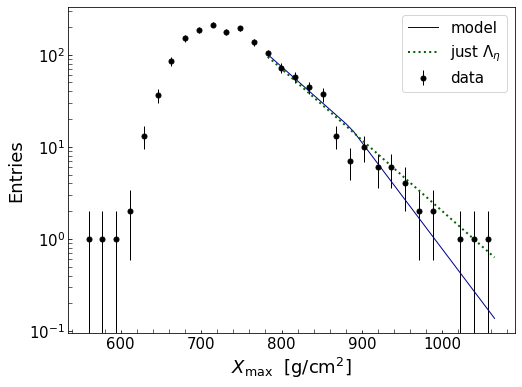

In [14]:
def func_A5(Xmax, XtailStart, lambdaEta, Xacc, lambdaAcc, norm):
    """
    Functional form describing the tail of the Xmax distribution. For values of Xmax where Xmax-Xstart>z0
    the additional exponential damping with lambdaAcc is added.
    
    This is Eq. (A.5) from Ref.[Phys. Rev. D 90, 122005 (2014)]. Note, that in the
    original version of the article the normalisation constant "k" was used instead of "1/k"
    in Eq. (A.5).
    
    Args:
        Xmax: input Xmax values, np.array
        XtailStart: start of tail fit range
        lambdaEta: Lambda_Eta
        Xacc: start of acceptance damping
        lambdaAcc: decay constant for acceptance damping
    """
    k = lambdaEta*(1 + np.exp(-(Xacc-XtailStart)/lambdaEta)*(lambdaAcc/(lambdaAcc+lambdaEta) - 1)) 
    z = Xmax - XtailStart
    result = np.exp(-z/lambdaEta)
    result[Xmax>Xacc] *= np.exp(-(Xmax[Xmax>Xacc]-Xacc)/lambdaAcc)
    return result/k * norm

plt.figure()

XmaxEntries, bins,_ = plt.hist(selectedXmaxData, 30, label='$18<lg(E/eV)<18.5$')
XmaxTailEntries,_ ,_ = plt.hist(XmaxTail, bins, label='$X_\mathrm{max}$ tail, $\eta=0.2$')
plt.close()
std = np.sqrt(XmaxEntries)

func_range = np.linspace(XtailStart, bins[-1], 30)

norm = (bins[1]-bins[0])*len(XmaxTail) 

fig, axes = plt.subplots(figsize=(8,6))
plt.errorbar(bins[0:-1]+np.diff(bins)/2, XmaxEntries, yerr=std, color='black', fmt='o', label='data')
plt.plot(func_range, func_A5(func_range, XtailStart, lambdaEta, acceptance['Xacc2'], acceptance['lambdaAcc2'], norm), 
         color='darkblue', lw=1, label='model')
plt.plot(func_range, np.exp(-(func_range-XtailStart)/lambdaEta)/lambdaEta * norm, ':', color='darkgreen', lw=2,
         label='just $\Lambda_\eta$')

plt.yscale('log')
plt.xlabel('$X_\mathrm{max}$  [g/cm$^2$]')
plt.ylabel('Entries')
axes.xaxis.set_minor_locator(MultipleLocator(20))
plt.legend()
plt.show()

The plot above shows the $X_\text{max}$ distribution for the selected energies and the unbinned likelihood fit to the tail of the $X_\text{max}$ distribution (the range of the $X_\text{max}$ values that corresponds to the fraction $\eta$ of the most deeply penetrating showers). The purely exponential fit $\propto \exp(-X_{\rm max}/\Lambda_\eta)$ is shown in the dotted green line, and the actual model fit with the additional exponential damping is shown in the solid blue line (see Eq.1). The visible kink around $\approx 900\,$g/cm$^{2}$ is caused by the acceptance of the telescopes starting to affect the distribution above $X_\text{acc}$. Note, there are no telescope acceptance effects visible below this value because the data was specifically selected in a fiducial volume to avoid any biases here. For a full discussion read the original article [Phys. Rev. D 90, 122005 (2014)](https://doi.org/10.1103/PhysRevD.90.122005) ([arXiv](https://arxiv.org/abs/1409.4809)).

### Conversion of $\Lambda_\eta$ fit result into proton-air cross section

The conversion is performed by simulating a very large sample of air showers with many different interaction models. For each model, artificially, the input model proton-air cross section is varied, $\sigma_\text{p-air}^\text{mod}$, and the resulting $\Lambda_\eta^\text{MC}$ values are measured. Details on this procedure are published here: [Hadronic Multiparticle Production at Ultra-High Energiesand Extensive Air Showers, Phys.Rev.D 83 (2011) 054026](https://doi.org/10.1103/PhysRevD.83.054026) ([arXiv](https://arxiv.org/abs/1010.4310)).

The results of these simulations are presented here:

In [15]:
# units of cross sections are in [mb]
sigmaPAirMC = [400, 430, 460, 490, 520, 550, 580, 610, 640, 670, 700]
# unit for all lambdaEtas are in [g/cm2]
lambdaEtaQgsjet01MC = [70.92, 66.20, 62.04, 58.39, 55.20, 52.43, 50.02, 47.93, 46.10, 44.50, 43.07] 
lambdaEtaQgsjetIIMC = [68.9915, 64.45, 60.42, 56.84, 53.67, 50.87, 48.38, 46.18, 44.20, 42.41, 40.76] 
lambdaEtaSibyll21MC = [67.44, 63.34, 59.62, 56.33, 53.36, 50.71, 48.36, 46.26, 44.40, 42.75, 41.26] 
lambdaEtaEposMC = [67.96, 63.30, 59.21, 55.65, 52.56, 49.89, 47.60, 45.63, 43.93, 42.45, 41.15] 

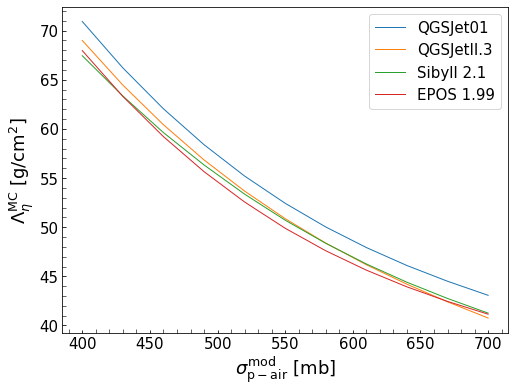

In [16]:
fig, axes = plt.subplots(figsize=(8,6))
plt.plot(sigmaPAirMC, lambdaEtaQgsjet01MC, label='QGSJet01')
plt.plot(sigmaPAirMC, lambdaEtaQgsjetIIMC, label='QGSJetII.3')
plt.plot(sigmaPAirMC, lambdaEtaSibyll21MC, label='Sibyll 2.1')
plt.plot(sigmaPAirMC, lambdaEtaEposMC, label='EPOS 1.99')
plt.legend()
plt.xlabel(r'$\sigma^\mathrm{mod}_\mathrm{p-air}$ [mb]')
plt.ylabel(r'$\Lambda_{\eta}^\mathrm{MC}$ [g/cm$^2$]')
axes.xaxis.set_minor_locator(MultipleLocator(10))
axes.yaxis.set_minor_locator(MultipleLocator(1))
plt.show()

These simulations must be inverted in order to provide the needed conversion curves from measured $\Lambda_{\eta}$ to $\sigma_\text{p-air}$. The different model predictions automatically provide an estimate of model-dependence. 

In [17]:
def interpolate(x, xi, yi):
    """
    returns the interpolation of x inside xi->yi, basically: $y(x)$
    Arg:
        x: target x value
        xi: list of x values
        yi: list of y values
    Return:
        interpolated y
    """
    # make sure xis and yis are sorted in ascending x
    inverted = sorted(zip(xi, yi), key = lambda t: t[0])
    return np.interp(x, [xs for xs,_ in inverted], [ys for _,ys in inverted])


def convertLambdaToSigma(lambdaEta):
    """
    perform the conversion from $\Lambda_\eta$ to $\sigma_{p-air}$ for all available models.

    Arg:
        lambdaEta: Lambda-Eta in units of g/cm2
    Return:
        dict with average value between all models, and 
        model-dependent uncertainties (lower/upper)
    """
    sigmas = np.array([interpolate (lambdaEta, model, sigmaPAirMC) 
                       for model in [lambdaEtaQgsjet01MC, lambdaEtaQgsjetIIMC, lambdaEtaSibyll21MC, lambdaEtaEposMC]])
    avg = sigmas.mean()
    return {'value': avg, 'errorLow': avg - sigmas.min(), 'errorUp': sigmas.max() - avg}


# central value
sigmaPAir = convertLambdaToSigma(lambdaEta)
# lower stat. uncertainty
sigmaPAir_stat_low = sigmaPAir['value'] - convertLambdaToSigma(lambdaEta+lambdaEtaError[1])['value']
# upper stat. uncertainty
sigmaPAir_stat_up = convertLambdaToSigma(lambdaEta-lambdaEtaError[0])['value'] - sigmaPAir['value']

print (f'The sigma-proton-air cross section is: {sigmaPAir["value"]:.2f} mb')
print (f'with a statistical uncertainty of -{sigmaPAir_stat_low:.2f}/+{sigmaPAir_stat_up:.2f} mb')
print (f'and systematic model-dependence of -{sigmaPAir["errorLow"]:.2f}/+{sigmaPAir["errorUp"]:.2f} mb')

The sigma-proton-air cross section is: 495.47 mb
with a statistical uncertainty of -36.65/+38.11 mb
and systematic model-dependence of -10.43/+14.76 mb


*Note*: other sources of systematic uncertainties related e.g. to fitting procedures, primary composition, etc. are not studied here.

## Visualize the conversion
The lines represent the average conversion from $\Lambda_\eta$ to $\sigma_\text{p-air}$.

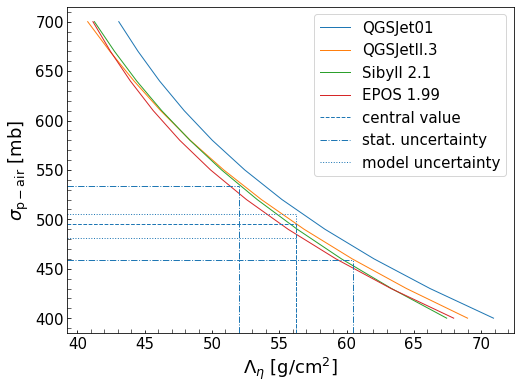

In [18]:
import matplotlib.lines as lines
import matplotlib.transforms as transforms

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lambdaEtaQgsjet01MC, sigmaPAirMC, label='QGSJet01')
ax.plot(lambdaEtaQgsjetIIMC, sigmaPAirMC, label='QGSJetII.3')
ax.plot(lambdaEtaSibyll21MC, sigmaPAirMC, label='Sibyll 2.1')
ax.plot(lambdaEtaEposMC, sigmaPAirMC, label='EPOS 1.99')
fig.canvas.draw()

def plotConversion(ax, lambdaEta, sigmaPAir, style, label=""):
    """
    Helper function to draw conversion lines into conversion figure.
    Args:
      ax: the figure axis
      lambdaEta: lambda_eta
      sigmaPAir: corresponding sigma-pair
      style: line style
      label: label
    """
    transX = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    transY = transforms.blended_transform_factory(ax.transAxes, ax.transData)

    lambdaAx, sigmaAx = ax.transAxes.inverted().transform(ax.transData.transform((lambdaEta,sigmaPAir)))
    
    ax.add_line(lines.Line2D([lambdaEta, lambdaEta], [0, sigmaAx], transform=transX, figure=fig, linestyle=style, 
                             label=label))
    ax.add_line(lines.Line2D([0, lambdaAx], [sigmaPAir, sigmaPAir], transform=transY, figure=fig, linestyle=style))

plotConversion(ax, lambdaEta, sigmaPAir['value'], "--", "central value")
plotConversion(ax, lambdaEta+lambdaEtaError[1], sigmaPAir['value']-sigmaPAir_stat_low, "-.", label="stat. uncertainty")
plotConversion(ax, lambdaEta-lambdaEtaError[1], sigmaPAir['value']+sigmaPAir_stat_up, "-.")
plotConversion(ax, lambdaEta, sigmaPAir['value']+sigmaPAir['errorLow'], ":")
plotConversion(ax, lambdaEta, sigmaPAir['value']-sigmaPAir['errorUp'], ":", "model uncertainty")

plt.legend()
plt.xlabel(r'$\Lambda_{\eta}$ [g/cm$^2$]')
plt.ylabel(r'$\sigma_\mathrm{p-air}$ [mb]')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.show()

## Comparison of the derived cross-section to model predictions

From the original event generator models used in the simulations the following data was extracted:

In [19]:
# from simulations:
# the energy values are in log_{10}(E/eV)
lgE0 = [14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0,
19.5]
# all sigmas are in units of [mb]
sigma_pair_sibyll23c = [334.73, 351.52, 370.13, 389.76, 410.27, 431.38, 452.93, 474.83, 496.98, 519.40, 542.07, 565.02]
sigma_pair_qgsjetII03 = [347.76, 366.46, 386.26, 407.52, 429.23, 451.37, 473.51, 495.43, 517.28, 538.97, 560.39, 581.45]
sigma_pair_epos = [349.97, 367.81, 386.40, 406.77, 427.51, 448.27, 468.97, 488.98, 508.95, 528.95, 548.91, 568.78]
sigma_pair_sibyll21 = [353.11, 373.08, 395.92, 419.85, 444.98, 471.05, 497.88, 525.42, 553.59, 582.41, 611.83, 641.82]

Plot simulation lines together with data:

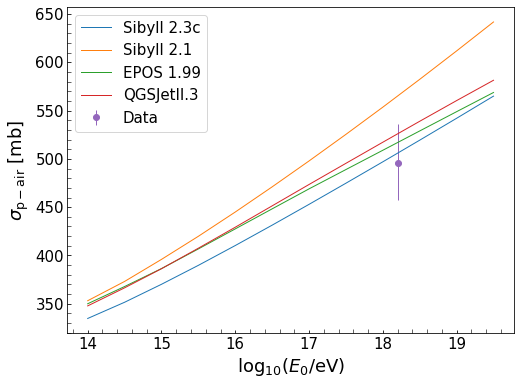

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(lgE0, sigma_pair_sibyll23c, label='Sibyll 2.3c')
plt.plot(lgE0, sigma_pair_sibyll21, label='Sibyll 2.1')
plt.plot(lgE0, sigma_pair_epos, label='EPOS 1.99')
plt.plot(lgE0, sigma_pair_qgsjetII03, label='QGSJetII.3')

avg_lgEdata = np.average(lgEData[(lgEData>lgELow)&(lgEData<lgEUp)])
plt.errorbar(avg_lgEdata, sigmaPAir['value'], yerr=np.array([[np.sqrt(sigmaPAir_stat_low**2 + sigmaPAir['errorLow']**2),
             np.sqrt(sigmaPAir_stat_up**2 + sigmaPAir['errorUp']**2)]]).T, fmt='o', ms=6, label="Data")

plt.legend()
plt.xlabel(r'$\log_{10}(E_{0}/\mathrm{eV})$')
plt.ylabel(r'$\sigma_\mathrm{p-air}$ [mb]')
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.show()

One conclusion of these data is that steeply rising cross sections (like in Sibyll 2.1) towards higher energies are disfavoured. 